In [1]:
import pandas as pd                                    #пандас для работы с дата фреймами 
import time                                            #время для того, чтобы гладко открывались страницы
import getpass                                         #билиотека для невидимого ввода 



from bs4 import BeautifulSoup as bs                    #для выкачки кода
from selenium import webdriver as wb                   #для окрытия браузера
#выкачиваю названия ошибок для отладки:
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, TimeoutException  


import string                                            #для чистки знаков и пунктуации                           
from nltk.tokenize import sent_tokenize, word_tokenize   #для чистки мусорных(минус) слов 
from nltk.corpus import stopwords                        
from pymystem3 import Mystem                             #для приведния слов в начльную форму 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  #для построения облака слов
import matplotlib.pyplot as plt                                  #для вывода облака


In [2]:
def wcloud():
    
    br = wb.Chrome("C:/Users/User/Desktop/chromedriver")
    br.get("https://briefly.ru/")                                      #открываю ссылку в брифли
    try: 
        name = getpass.getpass('Название произведения: ')              #ввожу название к поиску в браузере
        book_field = br.find_element_by_css_selector("#h-search-q")    #задаю поле поиска
        book_field.send_keys(name)                                     #отправил название книги в поиск
        time.sleep(3)
        button = br.find_element_by_css_selector("#h-search-suggests") #ищу куда кликнуть
        button.click()                                                 #кликаю
    
        soup = bs(br.page_source, 'lxml')                              #копирую и сохраняю код страницы 
        text = [a.text for a in soup.find_all('p')]                    #нашел текст с помощью тега p
        book_name = br.find_element_by_css_selector('#title').text     #нашел название книги
        book_author = br.find_element_by_css_selector('.breadcrumb__name').text    #нашел имя автора
        book_name1 = book_name.lower()                                  #убрал заглавные в названиях
        book_author = book_author.lower()                              #убрал заглавные имени автора 
        book_author = book_author.split()                              #делаю список из имени и фамилии автора
    
        urls = []                                                      #пустой список
        for link in soup.find_all('link'):                             #ищу все ссылки в head(HTML-код)
            if 'briefly' in link.get('href'):                          #нахожу саму саму ссылку с помощью атрибута HREF
                urls.append(link.get('href'))
        book_url = urls[0]                                             #получил ссылку на нужную статью btielfy из списка 
    
    
        def normalize(text):
            to_remove = string.punctuation + '«»—1234567890„“…<>'      #элементы(запятые и цифры) от которых нужно избавиться
            translator = str.maketrans('', '', to_remove)              #метод, заменящий знаки препинания на пустое значение
            res = text.translate(translator)                           #применение метода к тексту
            res = res.lower()                                          #убрать заглавные буквы в тексте 
        
            return res
    
        normalized = [normalize(c) for c in text]                     #очищаю текст от знаков препинаия 
        normalized = [n.replace('\xa0', ' ') for n in normalized]     #избавляюсь от мусора
        normalized = [n.replace('\xad', '') for n in normalized]
        normalized = [n.replace('\u2009', '') for n in normalized]
        str_text = ' '.join(normalized)                               #формирую строку из списка слов
        m = Mystem()                                                  #метод для приведнения в слов в начльную форму 
        lemmas = m.lemmatize(str_text)                                #получили список слов в начальной форме(леммы)
        lemma = "".join(lemmas)                                       #получили строку из слов 
    

        stopWords = set(stopwords.words('russian'))                   #задали стопслова на русском с помощью nltk
        #добывил стоп слов в set stopWords:
        stopWords.update({'который', 'свой', 'весь', 'это', 'поэтому'})   
        words = word_tokenize(lemma)                                  #разбиваем текст на слова
        wordsFiltered = []

        for w in words:
            if w not in stopWords:                                    #выбирем слова, которых не было в списке стопслов
                wordsFiltered.append(w)                               #получаю список нужных слов без стопслов

        final_string = ' '.join(wordsFiltered)                        #получаю финальный текст для облака слов
    
    
        df = pd.read_csv("https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/emo_dict/emo_dict.csv", 
                encoding = "UTF-8", sep = ";")                        #загрузим словарь тональности русского языка 


        pos_df = df[df['tag'] == 'PSTV']                              #создаем df из положительных слов                  
        neg_df = df[df['tag'] == 'NGTV']                              #создаем df из отрицательных слов 

        pos_list = list(pos_df['term'])                               #создаем список из положительных слов
        neg_list = list(neg_df['term'])                               #создаем список из отрицательных слов
        n_posword = 0
        for wf in wordsFiltered:                                      #цикл в списке отфильтрованных слов
            if wf in pos_list:                                        #если эл. в отф-анных словах есть в поззитвной выборке
                n_posword = n_posword + 1                             #добавляем слово к списку 
        n_negword = 0 
        for wf in wordsFiltered:                                      #та же логика для  негативных слов
            if wf in neg_list:  
                n_negword = n_negword + 1
        if  n_negword/n_posword > 0.33:                               #условный критерий для негативного текста
            
        #формирую облако слов, если текст черный, то текст в негативной тональноти: 
        #облако слов в черном для негатива:
            wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="black").generate(final_string)
            plt.imshow(wordcloud, interpolation='bilinear')           # для более плавного выведения облака  
            plt.axis("off")             
                                              
            print('Книга написана в негативной тональности')          #выведение тональности
            #выведение критерия тональности:
            print('Отношение позитвных к негативным словам:',n_negword/n_posword) 
                               
    
        else:  
            #облако слов в белом для позитивного текста:
            wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate(final_string)
            plt.imshow(wordcloud, interpolation='bilinear')           #для более плавного выведения облака
            plt.axis("off")
            print('Книга написана в позитивной тональности ')         #выведение тональности
             #выведение критерия тональности:
            print('Отношение позитвных к негативным словам:',n_negword/n_posword)   
        plt.show()                                                    #выведение облака
        guess_name = str(input('Угадайте название произведния:'))     #ввод названия книги для отгадки            
        guess_author = str(input('Угадайте фамилию автора:',))        #ввод имени автора для отгадки 
        check_n = guess_name.lower()                                  #привел имя и название к нижнему регистргу 
        check_a = guess_author.lower()
        
        if check_n == book_name1 and check_a in book_author:          #если ввод фамилии автора и его имя парвильное:
            print('Вы угадали название книги и автора.')              #вывожу текст
            print('Вы знаток литературы!')
              
        elif check_n == book_name1 and check_a not in book_author:    #если название ок, а автор не ок:
            print('Вы угдали название книги, но не угадали автора.')
            print('Узнать автора можете по ссылке:', book_url)
    
        elif check_n != book_name1 and check_a in book_author:        #если название не ок, а автор - ок:
            print("Вы угадали автора книги, но не название.")
            print('Узнать название книги можете по ссылке:', book_url)
        else: 
            print('Загадайте пользователю другое произведение')       #всё неправильно 
            print('Прочитать пересказ можно по ссылке:', book_url)
        br.close()                                                    #закрываю браузер
    except ElementNotVisibleException:                                #метод для правки ошибок
        print('Некорректно ввели название произведения. Попробуйте ещё раз!') #ошибка,если не так вбил навзание произведния
        br.close()                                              
    except NoSuchElementException:                                    #ошибка, если нет соединения
        print('Нет сети. Подключитесь к сети!')
        br.close()
    except HTTPError:                        
        print('Ошибка подключения')                                   #ошибка, если соеднение прервалось
        br.close()
    except TimeoutException:
        print('Ошибка подключения')                                   #ошибка, если соеднение прервалось
        br.close()
    return                                                                       


Название произведения: ········
Книга написана в негативной тональности
Отношение позитвных к негативным словам: 0.37259615384615385


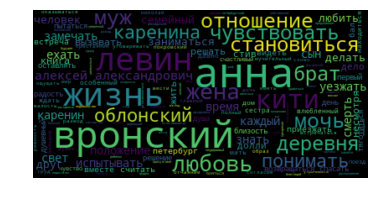

Угадайте название произведния:Анна Каренина
Угадайте фамилию автора:Толстой
Вы угадали название книги и автора.
Вы знаток литературы!


In [4]:
wcloud()

Название произведения: ········
Книга написана в позитивной тональности 
Отношение позитвных к негативным словам: 0.17365269461077845


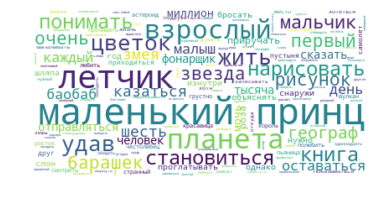

Угадайте название произведния:маленький принц
Угадайте фамилию автора:Сент-Экзюпери
Вы угадали название книги и автора.
Вы знаток литературы!


In [5]:
wcloud()

Название произведения: ········
Книга написана в негативной тональности
Отношение позитвных к негативным словам: 0.37462235649546827


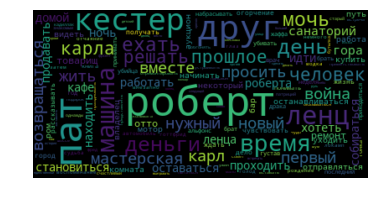

Угадайте название произведния:Три товарища
Угадайте фамилию автора:abc
Вы угдали название книги, но не угадали автора.
Узнать автора можете по ссылке: https://briefly.ru/remark/tri_tovaricsha/


In [7]:
wcloud()